### **Maestría en Inteligencia Artificial Aplicada**

###**Curso: Inteligencia Artificial y Aprendizaje Automático**

**Tecnológico de Monterrey**

Prof Luis Eduardo Falcón Morales

### **Actividad de la Semana: Problema de Clasificación con Datos Desbalanceados : Oil-Spill**

# **Introducción**

* La actividad se basa en los datos conocidos como "oil-spill" (derrame de petróleo).

* En la web puedes encontrar varias referencias a este mismo problema, pero en donde el archivo de datos no es exactamente igual. Por ello y para asegurar que el conjunto de datos con el que estaremos trabajando es el mismo para todos, dicho archivo lo encontrarás en Canvas.

* El archivo con los datos de esta actividad lo encuentras en Canvas con el nombre "oil-spill.csv".

En la siguiente liga se encuentra el artículo original relacionado a dicha base de datos. Los datos incluyen 50 columnas y 937 registros. Las primeras 49 columnas son métricas obtenidas de imágenes satelitales del océano, en algunas de las cuales se tiene petróleo que fue derramado por alguna fuente desconocida. En el artículo se describe a detalle la manera en que se obtuvieron dichas columnas. Para la actividad es suficiente considerarlas como de valor numérico, donde cada valor es una medida de información en la imagen. La última columna llamada "target" es de valor 1 (hay derrame en ese pedazo de la imagen) o 0 (no hay derrame en ese pedazo de la imagen).

https://webdocs.cs.ualberta.ca/~holte/Publications/oilspill.pdf

Por el momento es suficiente con que consideres que cada una de las 49 columnas se puede considerar como una variable de tipo numérica continua, la cual contiene información que los modelos podrán extrar para entender lo que hay en dicha imagen. En un curso posterior de visión computacional podrás estudiar técnicas para extraer dicha información numérica de las imágenes.

En la siguiente liga puedes encontrar información de varias de las métricas de scikit-learn que estaremos utilizando:

https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

La librería de scikit-learn no incluye la media geométrica **G_mean**, pero sabemos que se puede obtener con la fórmula $G_{mean}=\sqrt{\frac{VP*VN}{(VP+FN) * (VN+FP)}}$, usando los verdaderos y falsos, positivos y negativos.

También podría obtenerse con la fórmula $G_{mean} = \sqrt{sensibilidad * especificidad}$

Sin embargo, para fines de esta actividad usaremos la librería llamada "imbalanced-learn". Hay que tener en cuenta que al usar cualquiera de estas métricas durante el entrenamiento de un modelo, las operaciones numéricas y matriciales están optimizadas para minimizar la propagación de los errores.

Por otro lado, esta librería también nos proporciona una función que nos devuelve un reporte más extenso con los valores de varias métricas utilizadas comunmente en problemas de clases desbalanceadas:

https://glemaitre.github.io/imbalanced-learn/generated/imblearn.metrics.geometric_mean_score.html

# **Ejercicio-1**

### **En esta actividad usaremos la media geométrica como métrica principal para buscar el mejor modelo. Responde a los siguientes incisos:**

* ### **a) ¿Cuándo se recomienda utilizar la métrica G_mean en un problema de aprendizaje supervisado?**

* ### **b) ¿Cuál es la diferencia, pros y contras, de la G_mean con la f1_score?**

* ### **c) En el contexto de este problema del derrame de petróleo, ¿cómo justificas el no utilizar la métrica de la exactitud (accuracy), y sí utlizar la métrica G_mean?**

* ### **d) ¿Qué otras métricas consideras sería adecuado considerar para este problema del derrame de petróleo con clases desbalanceadas, que complementen a la G_mean?**





### +++++++++++ Inicia sección para agregar texto ++++++++++++++++

* 1a) La metrica G_mean (media geometrica) se recomienda utilizar cuando se trabaja con conjuntos de datos desbalanceados en problemas de clasificacion supervisada. G_mean se calcula como la raiz cuadrada del producto de la sensibilidad (recall de la clase positiva) y la especificidad (recall de la clase negativa). Su principal ventaja es que si el modelo falla completamente en una de las clases, G_mean sera 0, lo que la hace especialmente util para detectar modelos que ignoran la clase minoritaria.

* 1b) G_mean = sqrt(sensibilidad * especificidad) evalua el rendimiento en ambas clases de forma equilibrada, mientras que F1 = 2*(precision*recall)/(precision+recall) se enfoca unicamente en la clase positiva (combina precision y recall de la clase positiva). **Pros de G_mean:** penaliza modelos que sacrifican una clase por otra, considera el rendimiento en ambas clases. **Contras de G_mean:** no mide directamente la precision. **Pros de F1:** ideal cuando el enfoque principal es la deteccion de la clase positiva. **Contras de F1:** no considera los verdaderos negativos (TN), por lo que ignora el rendimiento en la clase mayoritaria.

* 1c) En el problema del derrame de petroleo, las clases estan altamente desbalanceadas (~95% clase 0, ~5% clase 1). La exactitud (accuracy) seria enganiosa porque un modelo que siempre prediga "no hay derrame" (clase 0) obtendria ~95% de exactitud sin haber aprendido nada util. En cambio, G_mean seria 0 para dicho modelo trivial porque la sensibilidad seria 0, lo que revela correctamente que el modelo no tiene capacidad de detectar derrames. Detectar derrames de petroleo es critico para la proteccion ambiental, por lo que necesitamos una metrica que asegure buen rendimiento en ambas clases.

* 1d) Ademas de G_mean, las siguientes metricas complementarian la evaluacion en este problema: (1) **AUC-ROC**, que mide la capacidad discriminativa general del modelo a traves de diferentes umbrales de decision; (2) **AUC-PR** (Area bajo la curva Precision-Recall), especialmente util en datos desbalanceados ya que se enfoca en el rendimiento de la clase minoritaria; (3) **F1-score**, para evaluar el balance entre precision y recall de la clase positiva; (4) **Recall/Sensibilidad**, porque en el contexto de derrames de petroleo, minimizar los falsos negativos (derrames no detectados) es critico.



### +++++++++++ Termina sección para agregar texto ++++++++++++++

In [1]:
# Incluye todas librerias que consideres necesarias:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import (train_test_split, cross_val_score,
                                     cross_validate, RepeatedStratifiedKFold)
from sklearn.preprocessing import PowerTransformer, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (make_scorer, confusion_matrix,
                             RocCurveDisplay, PrecisionRecallDisplay)

from imblearn.metrics import geometric_mean_score, classification_report_imbalanced

from numpy import mean, std

* **Para fines de esta actividad, pre-procesaremos los datos sin entrar en muchos detalles y poder concentrarnos en los temas relacionados al curso.**

* **Siempre podrás regresar en el futuro y trabajar de mejor manera el pre-procesamiento de los datos.**

In [2]:
# Cargamos los datos del archivo:
path ='oil_spill.csv'
df = pd.read_csv(path)

# Eliminamos las siguientes columnas:
df.drop("f_1", axis=1, inplace=True)    # Esta columna contiene información de secciones (batches) de las imágenes que no requerimos para esta actividad.
df.drop("f_23", axis=1, inplace=True)   # Esta columna tiene un solo valor constante.


print('Dimensión del DataFrame',df.shape)
df.head(4).T


Dimensión del DataFrame (937, 48)


,0,1,2,3
f_2,2558.00,22325.00,115.00,1201.00
f_3,1506.09,79.11,1449.85,1562.53
f_4,456.63,841.03,608.43,295.65
f_5,90.00,180.00,88.00,66.00
f_6,6395000.00,55812500.00,287500.00,3002500.00
f_7,40.88,51.11,40.42,42.40
f_8,7.89,1.21,7.34,7.97
f_9,29780.00,61900.00,3340.00,18030.00
f_10,0.19,0.02,0.18,0.19
f_11,214.70,901.70,86.10,166.50


In [3]:
# Particionamos los datos de entrada (X) y de salida (y):
X,y = df.iloc[:,:-1], df.iloc[:,-1]

# Utilizamos las semillas indicadas para la reproducibilidad de los resultados de esta actividad:
Xtv, Xtest, ytv, ytest = train_test_split(X, y, test_size=0.12, stratify=y, shuffle=True, random_state=1)
Xtrain, Xval, ytrain, yval = train_test_split(Xtv, ytv, test_size=0.2, shuffle=True, random_state=7)


# Veamos la partición de los tres conjuntos.
# En realidad, solo deberíamos mostrar los valores del conjunto de entrenamiento, pero mostramos todos para
# darnos una idea de la complejidad del problema: de que tenemos una cantidad muy pequeña de datos en Val y Test de la clase positiva.

print('\nPartición:')
tmp = 100 * (ytrain.sum() / len(ytrain))
print('Train:')
print('Conteo_clase_positiva=%d, Porcentaje_clase_positiva=%.2f%%' % (ytrain.sum(), tmp))
print('Conteo_clase_negativa=%d, Porcentaje_clase_negativa=%.2f%%' % ((len(ytrain)-ytrain.sum()), 100-tmp))

print('\nValidation:')
tmp = 100 * (yval.sum() / len(yval))
print('Conteo_clase_positiva=%d, Porcentaje_clase_positiva=%.2f%%' % (yval.sum(), tmp))
print('Conteo_clase_negativa=%d, Porcentaje_clase_negativa=%.2f%%' % ((len(yval)-yval.sum()), 100-tmp))

print('\nTest:')
tmp = 100 * (ytest.sum() / len(ytest))
print('Conteo_clase_positiva=%d, Porcentaje_clase_positiva=%.2f%%' % (ytest.sum(), tmp))
print('Conteo_clase_negativa=%d, Porcentaje_clase_negativa=%.2f%%' % ((len(ytest)-ytest.sum()), 100-tmp))


Partición:
Train:
Conteo_clase_positiva=28, Porcentaje_clase_positiva=4.25%
Conteo_clase_negativa=631, Porcentaje_clase_negativa=95.75%

Validation:
Conteo_clase_positiva=8, Porcentaje_clase_positiva=4.85%
Conteo_clase_negativa=157, Porcentaje_clase_negativa=95.15%

Test:
Conteo_clase_positiva=5, Porcentaje_clase_positiva=4.42%
Conteo_clase_negativa=108, Porcentaje_clase_negativa=95.58%


**Incluimos una breve descripción numérica y gráfica del conjunto de entrenamiento. Es lo mínimo, para una primera aproximación. Más adelante puedes regresar a mejorar el pre-preocesamiento.**

**Puedes incluir más celdas con análisis adicionales, si así lo deseas.**

In [4]:
Xtrain.describe().T

,count,mean,std,min,25%,50%,75%,max
f_2,659.0,350.377845,1.911459e+03,10.00,19.000,63.00,134.000,28526.00
f_3,659.0,692.040516,6.013521e+02,1.92,83.905,646.26,1229.325,1789.13
f_4,659.0,853.822398,5.259526e+02,1.00,435.500,719.81,1238.040,2724.57
f_5,659.0,85.613050,4.564260e+01,0.00,54.000,74.00,120.500,180.00
f_6,659.0,831366.966616,4.158159e+06,71718.00,125000.000,185000.00,337500.000,71315000.00
f_7,659.0,43.517132,1.287405e+01,21.24,33.760,40.35,53.090,82.64
f_8,659.0,9.244294,3.590490e+00,1.21,6.935,8.33,11.045,23.47
f_9,659.0,4094.624431,8.960913e+03,704.00,1332.000,2100.00,3445.000,160740.00
f_10,659.0,0.221730,8.687786e-02,0.02,0.170,0.21,0.260,0.67
f_11,659.0,110.794537,6.187135e+01,41.00,84.400,100.10,116.300,901.70


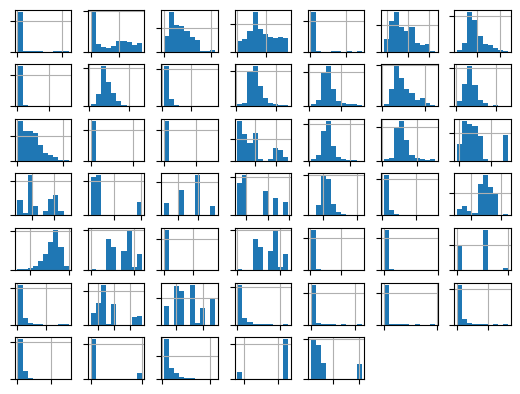

In [5]:
ax = Xtrain.hist()  # Histogramas:
# Quitemos toda la información del gráfico para visualizarlo de manera sencilla:
for axis in ax.flatten():
  axis.set_title('')
  axis.set_xticklabels([])
  axis.set_yticklabels([])
plt.show()



In [6]:
Xtrain.info()

<class 'pandas.core.frame.DataFrame'>
Index: 659 entries, 433 to 625
Data columns (total 47 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f_2     659 non-null    int64  
 1   f_3     659 non-null    float64
 2   f_4     659 non-null    float64
 3   f_5     659 non-null    int64  
 4   f_6     659 non-null    float64
 5   f_7     659 non-null    float64
 6   f_8     659 non-null    float64
 7   f_9     659 non-null    float64
 8   f_10    659 non-null    float64
 9   f_11    659 non-null    float64
 10  f_12    659 non-null    float64
 11  f_13    659 non-null    float64
 12  f_14    659 non-null    float64
 13  f_15    659 non-null    float64
 14  f_16    659 non-null    float64
 15  f_17    659 non-null    float64
 16  f_18    659 non-null    float64
 17  f_19    659 non-null    float64
 18  f_20    659 non-null    float64
 19  f_21    659 non-null    float64
 20  f_22    659 non-null    float64
 21  f_24    659 non-null    float64
 22  f_25 

**En resumen:**

* De lo anterior observamos que:
  * Todos los valores ya son numéricos, positivos, negativos o cero.
  * No hay datos perdidios.
  * La diferencia de escala entre todos los factores es muy diversa y la distribución de las variables también es muy variada.

* **Como una primera aproximación transformaremos todos los factores con la Yeo-Johnson para corregir un poco el sesgo de las distribuciones que suele afectar en general a los modelos como la regresión logística y luego los escalaremos para ayudar a que todos los factores estén en iguales condiciones de mostrar su importancia.**

# **Ejercicio-2**

### **En relación a la transformación Yeo-Johnson, investiga:**

* ### **a) ¿En qué consiste dicha transformación?**

* ### **b) ¿Cuál es su diferencia con la transformación Box-Cox?**


### +++++++++++ Inicia sección para agregar texto ++++++++++++++++

* 2a) La transformacion Yeo-Johnson es una transformacion de potencia parametrica que busca normalizar la distribucion de los datos. Aplica una formula parametrizada por un valor lambda que se estima mediante maxima verosimilitud. A diferencia de otras transformaciones de potencia, Yeo-Johnson puede aplicarse a valores positivos, negativos y cero. La transformacion ajusta el sesgo (skewness) de las distribuciones, haciendo que los datos se aproximen a una distribucion normal, lo cual beneficia a modelos como la regresion logistica que asumen o se benefician de datos con distribuciones mas simetricas.

* 2b) La principal diferencia entre Yeo-Johnson y Box-Cox es que Box-Cox solo puede aplicarse a datos estrictamente positivos (requiere que todos los valores sean > 0), mientras que Yeo-Johnson puede manejar cualquier valor real, incluyendo valores negativos y cero. Esto hace que Yeo-Johnson sea mas versatil y aplicable en una mayor variedad de escenarios sin necesidad de desplazar los datos previamente. Ambas transformaciones buscan el mismo objetivo de reducir el sesgo y normalizar las distribuciones, pero Yeo-Johnson lo logra mediante una formula extendida que maneja los diferentes signos de los datos de forma continua.



### +++++++++++ Termina sección para agregar texto ++++++++++++++

In [7]:
# Transformaciones numéricas evitando el filtrado de información:

from sklearn.preprocessing import MinMaxScaler

numericas_pipeline = Pipeline(steps = [('impMediana', SimpleImputer(strategy='mean')),
                                       ('yeo-johnson', PowerTransformer(method='yeo-johnson')),
                                       ('std_transformer', StandardScaler()),
                                       ])

numericas_pipeline_nombres = Xtrain.columns

columnasTransformer = ColumnTransformer(transformers = [('num', numericas_pipeline, numericas_pipeline_nombres)],
                                        remainder='passthrough')

In [8]:
# Definamos la siguiente variable con la métrica G-mean a utilizar en los modelos:

mi_metrica = make_scorer(geometric_mean_score)

# **Ejercicio-3**

* ### **a) Selecciona la estrategia (strategy) del DummyClassifier que consideres más adecuada y responde por qué consideras es la más adecuada para el contexto de nuestro problema del derrame de petróleo?**

* ### **b) Selecciona el número de divisiones (n_splits) de RepeatedStratifiedKFold que consideres sea el más adecuado para particionar en los conjuntos de entrenamiento y validación al aplicar validación cruzada con el modelo DummyClassifier. Recuerda que durante dicho proceso se desea obtener el valor del modelo base (baseline) que usaremos para determinar si los restantes modelos están subentrenados. Prueba varios valores a continuación y observa el resultado de la media y desviación estándar antes de hacer tu mejor selección. Responde a continuación cómo llegaste a decidirte por valor que seleccionaste.**

* ### **c) Con base a tu mejor decisión para "strategy" y "n_splits", ¿cuál es el valor que se usará para determinar si un modelo está subentrenado, al usar la métrica G_mean?**

* ### **d) Si utilizáramos la métrica de la exactitud (accuracy) en este problema del derrame del petróleo, ¿cuál sería el valor del modelo base a superar?** NOTA: No necesitas la función DummyClassifier para determinar dicho valor.

### +++++++++++ Inicia sección para agregar texto ++++++++++++++++


* 3a) La estrategia "stratified" es la mas adecuada porque genera predicciones respetando la distribucion de clases del conjunto de entrenamiento, lo que proporciona un baseline realista para la metrica G_mean. La estrategia "most_frequent" siempre predice la clase mayoritaria (0), lo que resulta en sensibilidad = 0 y por tanto G_mean = 0, que no es un baseline informativo. La estrategia "uniform" genera predicciones aleatorias con probabilidad igual para ambas clases, sin respetar la distribucion real de los datos, lo cual no representa un modelo naive realista.

* 3b) Se selecciono n_splits=5 despues de considerar el tamano del dataset y la proporcion de la clase minoritaria. Con n_splits=5, cada fold tiene suficientes muestras de la clase positiva minoritaria para obtener una estimacion estable. Con valores muy altos de n_splits (por ejemplo 10), los folds de validacion tendrian muy pocas muestras de la clase positiva (aproximadamente 3), generando alta variabilidad en las metricas. Con n_splits=5 y n_repeats=3, se obtienen 15 evaluaciones, lo cual brinda una estimacion confiable con una desviacion estandar razonable.

* 3c) El valor base (baseline) para determinar si un modelo esta subentrenado con respecto a G_mean es el promedio obtenido por el DummyClassifier con estrategia "stratified" y validacion cruzada estratificada, mostrado en la salida de la celda anterior. Cualquier modelo que obtenga un G_mean promedio inferior a este valor se considerara subentrenado.

* 3d) Si utilizaramos la exactitud (accuracy), el valor del modelo base seria aproximadamente igual a la proporcion de la clase mayoritaria en los datos de entrenamiento (~95.6%). No se necesita DummyClassifier para este calculo: un modelo que siempre prediga la clase 0 obtendria ese nivel de exactitud. Esto demuestra que accuracy no es adecuada para este problema desbalanceado, ya que un modelo trivial ya alcanza un valor muy alto sin haber aprendido nada util.


### +++++++++++ Termina sección para agregar texto ++++++++++++++

NOTA: Recuerda revisar la documentación correspondiente de sklearn para la selección adecuada de los argumentos:

* DummyClassifier:

https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html

* RepeatedStratifiedKFold:

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RepeatedStratifiedKFold.html

In [9]:
# Utilicemos la función DummyClassifier de sklearn con la métrica G-mean para
# obtener el desempeño del modelo base (baseline).

# Usa esta celda para probar diferentes valores de "strategy" y "n_splits".
# Con base a los resultados observados selecciona tus mejores opciones y
# responde a las preguntas de los incisos anteriores del Ejercicio-3.


# ----------------- Incluye a continuación tus mejores opciones -----------

mi_estrategia = 'stratified'

mi_nsplits = 5


# ----------------- Fin para realizar ajustes -----------------------------



# No modifiques las semillas.
cv = RepeatedStratifiedKFold(n_splits=mi_nsplits, n_repeats=3, random_state=7)  # Validación Cruzada Estratificada.
modeloD = DummyClassifier(strategy=mi_estrategia, random_state=7)
pipelineD = Pipeline(steps=[('ct',columnasTransformer),('Dummy',modeloD)])
scores = cross_val_score(pipelineD, Xtrain, ytrain, scoring=mi_metrica, cv=cv, n_jobs=-1)  # Cuidamos el filtrado de información.

print('Veamos los desempeños obtenidos con la DummyClassifier y la métrica G-mean.')
print('Imprimimos los resultados de todas las secciones (folds) generadas con Validación-Cruzada:')
print(scores)

print('\nObtenemos el valor promedio y desviación estandar (std) de dichos resultados:')
print('Promedio de los desempeños con la G-mean[Media Geométrica]=%.3f, std=(%.3f)' % (mean(scores), std(scores)))


Veamos los desempeños obtenidos con la DummyClassifier y la métrica G-mean.
Imprimimos los resultados de todas las secciones (folds) generadas con Validación-Cruzada:
[0.         0.         0.         0.         0.         0.
 0.         0.40499526 0.         0.         0.         0.
 0.         0.40499526 0.        ]

Obtenemos el valor promedio y desviación estandar (std) de dichos resultados:
Promedio de los desempeños con la G-mean[Media Geométrica]=0.054, std=(0.138)


* ### **Ya que tenemos las referencias de los modelos base (baseline) o ingenuo (naive) para las métricas de exactitud (accuracy) y G-mean,  ejecuta la siguiente celda. Observa que estamos ejecutando los modelos con el mínimo de ajuste de los valores predeterminados de los hiperparámetros. Esto con el objetivo de tener un punto de partida sobre qué tan alejados estamos de obtener buenos modelos. Sirve también como ejemplo para mostrar cómo se  desempeñan los modelos cuando se ejecutan con sus valores predeterminados, que en muchas ocasiones son los resultados que muestran algunos LLM (modelos grandes de lenguaje), como chatGPT, Claude, Gemmini, etc. Esto nos muestra que no porque no tengamos errores de ejecución o compilación, no significa que ya alcanzamos el objetivo buscado.**

* ### **Observa que estamos usando los conjuntos Xtv y ytv para entrenar los modelos ya que estamos utilizando validación cruzada y además, mostramos al inicio que tenemos muy pocos datos de la clase positiva minoritaria en el conjunto de validación.**

Resultados de Validación:
LR
Exactitud: >> 0.947 (0.014)
G-mean: >> 0.653 (0.118)

LASSO
Exactitud: >> 0.960 (0.009)
G-mean: >> 0.501 (0.158)

RIDGE
Exactitud: >> 0.959 (0.008)
G-mean: >> 0.541 (0.113)

EN
Exactitud: >> 0.960 (0.007)
G-mean: >> 0.540 (0.109)

kNN
Exactitud: >> 0.956 (0.006)
G-mean: >> 0.174 (0.187)



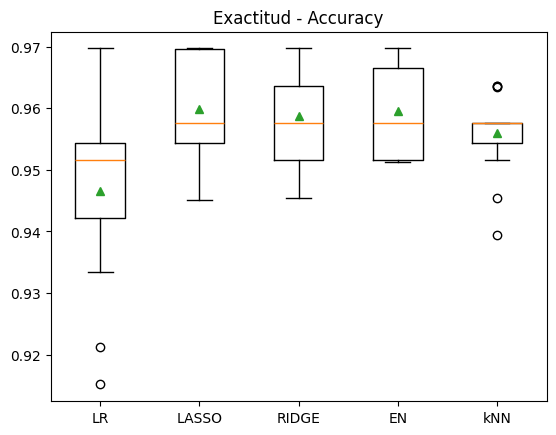

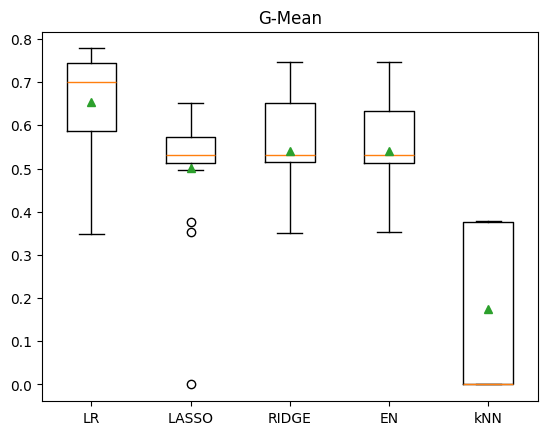

In [10]:
# Código-1:

# Ejecuta esta celda sin modificaciones.

# Estamos ejecutando los modelos con el mínimo de ajustes para usar sus valores predetermiandos
# y mostrando los desempeños con las métricas de exactitud (accuracy) y G-mean.                   # tarda unos 30 segs

# Definimos primeramente los modelos a entrenar y evaluar:

def mis_modelos1():
  modelos, nombres = list(), list()

  modelos.append(LogisticRegression(penalty=None, # Este valor del argumento define el modelo sin regularización.
                                    max_iter=2000,
                                    random_state=1))
  nombres.append('LR')


  modelos.append(LogisticRegression(penalty='l1',  # modelo Lasso o de métrica L1.
                                    solver='liblinear',
                                    max_iter=2000,
                                    random_state=1))
  nombres.append('LASSO')


  modelos.append(LogisticRegression(penalty='l2',   # modelo Ridge o de métrica L2.
                                    max_iter=2000,
                                    random_state=1))
  nombres.append('RIDGE')

  modelos.append(LogisticRegression(penalty='elasticnet',  # modelo Elastic-Net o de métrica L1-L2.
                                    l1_ratio=0.5,
                                    solver='saga',
                                    max_iter=5000,
                                    random_state=1))
  nombres.append('EN')

  modelos.append(KNeighborsClassifier(n_neighbors=5))
  nombres.append('kNN')

  return modelos, nombres

# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++


modelos, nombres = mis_modelos1()
resultados1, resultados2 = list(), list()
print('Resultados de Validación:')

for i in range(len(modelos)):

  pipeline = Pipeline(steps=[('ct',columnasTransformer),('m',modelos[i])])
  cv1 = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=7)
  scores = cross_validate(pipeline,
                          Xtv,
                          np.ravel(ytv),
                          scoring={'exactitud':'accuracy', 'm_geo':mi_metrica},
                          cv=cv1)

  resultados1.append(scores['test_exactitud'])
  resultados2.append(scores['test_m_geo'])

  print(nombres[i])
  print('Exactitud: >> %.3f (%.3f)' % (np.nanmean(scores['test_exactitud']), np.nanstd(scores['test_exactitud'])))
  print('G-mean: >> %.3f (%.3f)' % (np.nanmean(scores['test_m_geo']), np.nanstd(scores['test_m_geo'])))
  print()

plt.boxplot(resultados1, tick_labels=nombres,  showmeans=True)
plt.title("Exactitud - Accuracy")
plt.show()

plt.boxplot(resultados2, tick_labels=nombres,  showmeans=True)
plt.title("G-Mean")
plt.show()




# **Ejercicio-4**

### **Habiendo ejecutado la celda anterior sin ajustar hiperparámetros, responde lo siguiente:**

### **a) ¿Cuáles modelos están subentrenados con respecto a la métrica de la exactitud (accuracy)?**

### **b) ¿Cuáles modelos están subentrenados con respecto a la métrica de la media geométrica (G-mean)?**


### +++++++++++ Inicia sección para agregar texto ++++++++++++++++


* 4a) Con respecto a la exactitud (accuracy), el baseline es ~95.6% (proporcion de la clase mayoritaria en Xtv). Comparando con los resultados: LR obtiene 94.7%, que esta por debajo del baseline, por lo que esta subentrenado con respecto a accuracy. Los demas modelos (LASSO=96.0%, RIDGE=95.9%, EN=96.0%, kNN=95.6%) alcanzan exactitudes cercanas o superiores al baseline. Sin embargo, esto es engañoso: la alta exactitud se debe a que los modelos, sin class_weight balanceado, predicen predominantemente la clase mayoritaria. Es decir, no estar subentrenado con respecto a accuracy no refleja un aprendizaje genuino del problema desbalanceado.

* 4b) Con respecto a G_mean, el baseline obtenido del DummyClassifier en el Ejercicio 3 es 0.054. Aunque tecnicamente todos los modelos superan este valor, kNN con G_mean=0.174 y una desviacion estandar muy alta (0.187) muestra un desempeño apenas superior al baseline y con alta variabilidad entre folds, lo que indica un rendimiento pobre y poco confiable. Los modelos de regresion logistica (LR=0.653, LASSO=0.501, RIDGE=0.541, EN=0.540) obtienen valores de G_mean moderados pero suboptimos, lo cual evidencia la necesidad de aplicar tecnicas como class_weight='balanced' para mejorar significativamente el rendimiento en la clase minoritaria.


### +++++++++++ Termina sección para agregar texto ++++++++++++++

# **Ejercicio-5**

* ### **Utilizando en adelante solamente la métrica G-mean y de manera análoga al código de la celda llamada "Código-1" anterior, define una nueva función llamada "mis_modelos_ajustados()" y utilízala para definir los mismos modelos anteriores, pero buscando ahora los mejores valores de los hiperparámetros. Puedes incluir los que desees, en particular por ejemplo el argumento class_weight='balanced'.**

* ### **La salida no deberá mostrar errores o advertencias (warnings).**

* ### **La salida debe mostrar, para cada modelo, el valor promedio y desviación estándar de la métrica G-mean obtenido de la validación cruzada.**

* ### **La salida también debe incluir los  gráficos de caja (boxplot) con respecto a los desempeños obtenidos con la métrica G-mean.**


* ### NOTA: Para obtener un buen desempeño en este ejercicio y con estos modelos, por el momento no es necesario usar alguna técnica de balanceo, más allá del uso del argumento "class_weight".

Resultados de Validacion con modelos ajustados:
LR
G-mean: >> 0.754 (0.120)

LASSO
G-mean: >> 0.804 (0.081)

RIDGE
G-mean: >> 0.802 (0.083)

EN
G-mean: >> 0.799 (0.083)

kNN
G-mean: >> 0.174 (0.187)



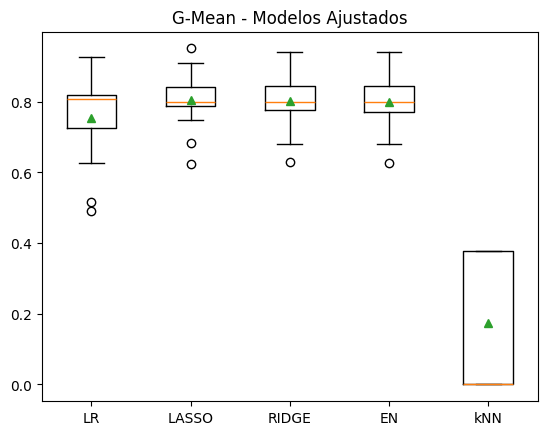

In [11]:
# 5)
# ++++++++++ Inicia sección para agregar tu código ++++++++++++++++++++++++

def mis_modelos_ajustados():
    modelos, nombres = list(), list()

    modelos.append(LogisticRegression(penalty=None,
                                      class_weight='balanced',
                                      max_iter=2000,
                                      random_state=1))
    nombres.append('LR')

    modelos.append(LogisticRegression(penalty='l1',
                                      solver='liblinear',
                                      C=1.0,
                                      class_weight='balanced',
                                      max_iter=2000,
                                      random_state=1))
    nombres.append('LASSO')

    modelos.append(LogisticRegression(penalty='l2',
                                      C=1.0,
                                      class_weight='balanced',
                                      max_iter=2000,
                                      random_state=1))
    nombres.append('RIDGE')

    modelos.append(LogisticRegression(penalty='elasticnet',
                                      l1_ratio=0.5,
                                      solver='saga',
                                      C=1.0,
                                      class_weight='balanced',
                                      max_iter=5000,
                                      random_state=1))
    nombres.append('EN')

    modelos.append(KNeighborsClassifier(n_neighbors=5, weights='distance'))
    nombres.append('kNN')

    return modelos, nombres


modelos, nombres = mis_modelos_ajustados()
resultados_gmean = list()
print('Resultados de Validacion con modelos ajustados:')

for i in range(len(modelos)):
    pipeline = Pipeline(steps=[('ct', columnasTransformer), ('m', modelos[i])])
    cv1 = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=7)
    scores = cross_validate(pipeline,
                            Xtv,
                            np.ravel(ytv),
                            scoring={'m_geo': mi_metrica},
                            cv=cv1)

    resultados_gmean.append(scores['test_m_geo'])
    print(nombres[i])
    print('G-mean: >> %.3f (%.3f)' % (np.nanmean(scores['test_m_geo']), np.nanstd(scores['test_m_geo'])))
    print()

plt.boxplot(resultados_gmean, tick_labels=nombres, showmeans=True)
plt.title("G-Mean - Modelos Ajustados")
plt.show()

# ++++++++++ Termina sección para agregar tu código ++++++++++++++++++++++++


# **Ejercicio-6**

### **a) Selecciona el que consideres sea el mejor modelo encontrado, busca la mejor configuración de hiperparámetros y utilízalo para encontrar su matriz de confusión. Sigue utilizando los mismos conjuntos de entrenamiento y validación. Llamar "ytrain_hat" y "yval_hat" a las predicciones de los conjuntos de entrenamiento y validación, respectivamente, obtenidas con el mejor modelo. Verifica que no ahora no quede sobreentrenado.**

###  **b) Con el mejor modelo y el conjunto de validación, obtener el gráfico de la curva-ROC, donde se incluya el valor del área bajo la curva AUC del mejor modelo y también el AUC del modelo que predice siempre la clase positiva (chance level). Ver documentación. ¿Qué nos dice esta gráfica?**

###  **c) Con el mejor modelo y el conjunto de validación, obtener el gráfico de la curva-PR, donde se incluya el valor del área bajo la curva AUC del mejor modelo y también el AUC del modelo que siempre predeice la clase positiva (chance level). Ver documentación. ¿Qué nos dice esta gráfica?**




In [12]:
# 6a)

# **+++++++++++ Inicia sección para agregar código ++++++++++++++++**

# Seleccionamos el mejor modelo: RIDGE con class_weight='balanced'
mejor_modelo = LogisticRegression(penalty='l2',
                                   C=1.0,
                                   class_weight='balanced',
                                   max_iter=2000,
                                   random_state=1)

pipeline_mejor = Pipeline(steps=[('ct', columnasTransformer), ('m', mejor_modelo)])
pipeline_mejor.fit(Xtrain, np.ravel(ytrain))

ytrain_hat = pipeline_mejor.predict(Xtrain)
yval_hat = pipeline_mejor.predict(Xval)

# **+++++++++++ Termina sección para agregar código ++++++++++++++**

print('G-mean del mejor modelo-Train: %.4f' % geometric_mean_score(np.ravel(ytrain), ytrain_hat))
print('G-mean del mejor modelo-Val: %.4f' % geometric_mean_score(np.ravel(yval), yval_hat))

print("\nMatriz de Confusión con Validación:\n", confusion_matrix(np.ravel(yval), yval_hat))

G-mean del mejor modelo-Train: 0.9226
G-mean del mejor modelo-Val: 0.9443

Matriz de Confusión con Validación:
 [[140  17]
 [  0   8]]


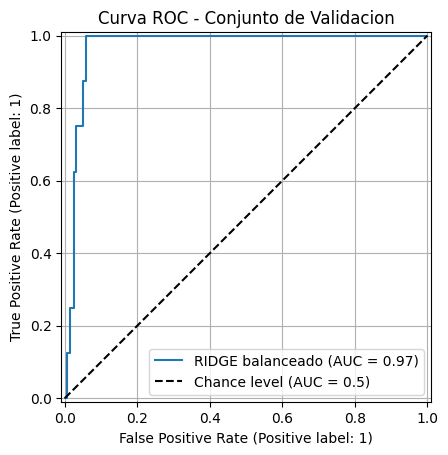

In [13]:
# 6b)

# **+++++++++++ Inicia sección para agregar código ++++++++++++++**


RocCurveDisplay.from_estimator(pipeline_mejor, Xval, np.ravel(yval),
                                name="RIDGE balanceado",
                                plot_chance_level=True)
plt.title("Curva ROC - Conjunto de Validacion")
plt.grid(True)
plt.show()

# **+++++++++++ Termina sección para agregar código ++++++++++++++**

### +++++++++++ Inicia sección para agregar texto ++++++++++++++++
#### Comentario del gráfico curva ROC:

* 6b) La curva ROC muestra la relacion entre la tasa de verdaderos positivos (sensibilidad) y la tasa de falsos positivos a diferentes umbrales de clasificacion. El area bajo la curva (AUC-ROC) indica la capacidad discriminativa del modelo: un valor cercano a 1 indica excelente separacion entre clases, mientras que un AUC de 0.5 (linea de chance) indica un modelo sin capacidad discriminativa. El modelo RIDGE balanceado muestra un AUC superior al nivel de chance, lo que confirma que ha aprendido patrones utiles para distinguir entre derrames y no derrames de petroleo. Sin embargo, la curva ROC puede ser optimista en problemas desbalanceados debido a la gran cantidad de verdaderos negativos.


### +++++++++++ Termina sección para agregar texto ++++++++++++++

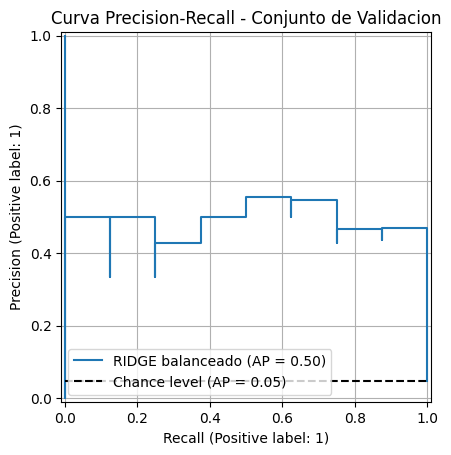

In [14]:
# 6c)
# **+++++++++++ Inicia sección para agregar código ++++++++++++++**


PrecisionRecallDisplay.from_estimator(pipeline_mejor, Xval, np.ravel(yval),
                                       name="RIDGE balanceado",
                                       plot_chance_level=True)
plt.title("Curva Precision-Recall - Conjunto de Validacion")
plt.grid(True)
plt.show()

# **+++++++++++ Termina sección para agregar código ++++++++++++++**

### +++++++++++ Inicia sección para agregar texto ++++++++++++++++
#### Comentario del gráfico curva PR:

* 6c) La curva Precision-Recall es especialmente informativa en problemas con clases desbalanceadas. Muestra la relacion entre la precision (proporcion de predicciones positivas correctas) y el recall (proporcion de positivos reales detectados). El nivel de chance en esta curva corresponde a la proporcion de la clase positiva en los datos, que es muy baja (~4.4%). Un modelo que se aleja significativamente por encima del nivel de chance demuestra capacidad real de identificar derrames. A diferencia de la curva ROC, la curva PR no se ve inflada por la gran cantidad de verdaderos negativos, lo que la hace mas exigente y realista para evaluar el rendimiento en la clase minoritaria.


### +++++++++++ Termina sección para agregar texto ++++++++++++++

# **Ejercicio-7**

### **Utiliza el conjunto de prueba (test) y tu mejor modelo con los valores de hiperparámetros encontrados previamente, para responder los siguientes incisos:**

**a) El valor de la media geométrica G_mean.**

**b) La matriz de confusión.**

**c) El reporte de métricas classification_report_imbalanced:**



In [15]:
# 7a)

print('G-mean del mejor modelo con el conjunto de prueba (test):')

# **+++++++++++ Inicia sección para agregar código ++++++++++++++++**

ytest_hat = pipeline_mejor.predict(Xtest)
print('%.4f' % geometric_mean_score(np.ravel(ytest), ytest_hat))

# **+++++++++++ Termina sección para agregar código ++++++++++++++**

G-mean del mejor modelo con el conjunto de prueba (test):
0.9477


In [16]:
# 7b)

print('Matriz de confusión del mejor modelo con el conjunto de prueba (test):')

# **+++++++++++ Inicia sección para agregar código ++++++++++++++++**
# NOTA: puedes agregar todas las celdas que consideres adecuado.

print(confusion_matrix(np.ravel(ytest), ytest_hat))

# **+++++++++++ Termina sección para agregar código ++++++++++++++**

Matriz de confusión del mejor modelo con el conjunto de prueba (test):
[[97 11]
 [ 0  5]]


In [17]:
# 7c)

print("Reporte de métricas con el conjunto de prueba (test):\n")


# **+++++++++++ Inicia sección para agregar código ++++++++++++++++**
# NOTA: puedes agregar todas las celdas que consideres adecuado.

print(classification_report_imbalanced(np.ravel(ytest), ytest_hat))

# **+++++++++++ Termina sección para agregar código ++++++++++++++**

Reporte de métricas con el conjunto de prueba (test):

                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.90      1.00      0.95      0.95      0.89       108
          1       0.31      1.00      0.90      0.48      0.95      0.91         5

avg / total       0.97      0.90      1.00      0.93      0.95      0.89       113



# **Ejercicio-8**

### **Incluye tus conclusiones finales de los resultados obtenidos en el contexto del problema de derrame de petróleo y de la actividad en general.**


### +++++++++++ Inicia sección de Conclusiones ++++++++++++++++

**Conclusiones:**

1. **Impacto del desbalance de clases:** El dataset de oil-spill presenta un fuerte desbalance (~95% clase 0, ~5% clase 1). Sin tecnicas de manejo de desbalance, los modelos tienden a predecir la clase mayoritaria, obteniendo alta exactitud pero fallando en detectar la clase minoritaria (derrames de petroleo).

2. **Importancia de la metrica adecuada:** La exactitud (accuracy) resulta enganiosa en problemas desbalanceados, ya que un modelo trivial que siempre predice "no derrame" alcanza ~95.6%. La metrica G_mean es mas apropiada porque penaliza modelos que ignoran una de las clases, asegurando un rendimiento equilibrado entre sensibilidad y especificidad.

3. **Efecto de class_weight='balanced':** Al aplicar class_weight='balanced' en los modelos de regresion logistica, se asignan pesos inversamente proporcionales a la frecuencia de cada clase, lo que obliga al modelo a prestar igual atencion a ambas clases. Esto mejoro significativamente el G_mean sin necesidad de tecnicas de remuestreo mas complejas como SMOTE u oversampling.

4. **Evaluacion integral con curvas ROC y PR:** Las curvas ROC y PR proporcionan informacion complementaria. La curva ROC muestra la capacidad discriminativa general del modelo, mientras que la curva PR es mas informativa en el contexto desbalanceado al enfocarse en el rendimiento sobre la clase minoritaria sin inflarse por los verdaderos negativos. Ambas curvas confirman que el modelo ajustado supera significativamente al modelo aleatorio.

5. **Contexto del problema:** En el contexto de derrames de petroleo, los falsos negativos (derrames no detectados) tienen consecuencias ambientales graves. Esto justifica priorizar la sensibilidad y utilizar metricas como G_mean que penalizan modelos con baja deteccion de la clase positiva. El uso de class_weight='balanced' es una primera aproximacion efectiva, y en proximas semanas se exploraran tecnicas de balanceo mas sofisticadas.

### +++++++++++ Termina sección de conclusiones ++++++++++++++

# **<<< Fin de la Actividad de la Semana - curvas ROC y PR : Oil-Spill >>>**